In [1]:
%matplotlib inline
%matplotlib notebook
import os
import cv2
from PIL import Image, ImageOps
import numpy as np
import torch
#from torch import nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import pytorch_lightning as pl

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev/4.png") as img:
    print(img.size)
    display(img)

In [ ]:
with Image.open("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_rgb_img/0.png") as img:
    display(img)
    plt.imshow(img)

In [ ]:
bev_frms = [file for file in os.listdir("./data/A_Spot_Library_Dobie_Wed_Nov_10_57_lidar_bev")]
len(bev_frms)

In [ ]:
fig, ax = plt.subplots()
ims = []
idx = 57
for i in range(idx,idx + 50):
    with Image.open(f"./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev/{i}.png") as img:
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.show()

In [ ]:
img = cv2.imread("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev/414.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(7,7), num=3)
plt.imshow(img)
#img = cv2.GaussianBlur(img, (7, 7), 0)
img = cv2.medianBlur(img, 5)
print(img.shape)
plt.figure(figsize=(7,7), num=4)
plt.imshow(img)
img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(7,7), num=5)
img[150:,:] = 0
plt.imshow(img)

In [ ]:
output = cv2.connectedComponentsWithStats(img, 8)
(numLabels, labels, stats, centroids) = output
output

# min area = 10
# max area = 70
# min height/width = 3
# max height/width = 15

In [ ]:
import math
objs = []
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]

    if((area>10) and (area<70)):
        objs.append(centroids[i])
objs = np.array(objs)
for obj in objs:
    print(obj)

In [ ]:
i = 3
# if this is the first component then we examine the
# *background* (typically we would just ignore this
# component in our loop)
if i == 0:
    text = "examining component {}/{} (background)".format(
        i + 1, numLabels)
# otherwise, we are examining an actual connected component
else:
    text = "examining component {}/{}".format( i + 1, numLabels)
# print a status message update for the current connected
# component
print("[INFO] {}".format(text))
# extract the connected component statistics and centroid for
# the current label
x = stats[i, cv2.CC_STAT_LEFT]
y = stats[i, cv2.CC_STAT_TOP]
w = stats[i, cv2.CC_STAT_WIDTH]
h = stats[i, cv2.CC_STAT_HEIGHT]
area = stats[i, cv2.CC_STAT_AREA]
(cX, cY) = centroids[i]

output = img.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
print(output.shape)
plt.figure()
plt.imshow(output)

In [ ]:
def process_img(path):
    """ Takes image path as input and returns list of centroids """

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.medianBlur(img, 5)
    img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]

    output = cv2.connectedComponentsWithStats(img, 8)
    (numLabels, labels, stats, centroids) = output

    objs = []
    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        if((area>10) and (area<70)):
            centroids[i][0] = (centroids[i][0] - dx)*res
            centroids[i][1] = (dy - centroids[i][1])*res
            objs.append(centroids[i])
    #print(len(objs))
    return objs

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=120) #figsize=(7, 3.5), 
axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(frame, cmap = plt.cm.gray, origin='lower')
axs[0].set_title('2D Lidar BEV')
axs[1].imshow(frame, cmap = plt.cm.gray, origin='lower')
axs[1].set_title('Tracking Trajectory')

In [ ]:
import pickle
from data_prep.MOTrajectory import extract_traj
pose_data = pickle.load(open("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_pose.pkl", 'rb'))
idx = 857
#print(pose_data['pose_sync'][idx])
poses = pose_data['pose_sync'][idx:idx+50]
traj = extract_traj("./data/A_Spot_Butler_Foodtruck_Fri_Nov_26_132_lidar_bev", idx, poses, 50)
print(len(traj))

In [ ]:
a = torch.from_numpy(np.array(traj)).to(torch.float32)
b = a.unsqueeze(dim=0)
B, O, N, C = b.shape
c = torch.zeros(B,O,2).unsqueeze(dim=2)
c = torch.cat([c,b], dim=2)
c.shape
c[:,:,:-1].shape

In [ ]:
import math
n_idx = 7
print(len(traj[n_idx]))
dist = []
for i in range(len(traj[n_idx])):
    dist.append(math.dist(traj[n_idx][0], traj[n_idx][i]))
print(np.std(dist))
np.array(traj[n_idx])

In [ ]:
plt.figure(figsize=(7,7))
# obj_idx = 7
# traj_np = np.array(traj[obj_idx])
for i,t in enumerate(traj):
    traj_np = np.array(t)
    plt.scatter(traj_np[:,0], traj_np[:,1], alpha=0.3, label=f"mot_{i}")
plt.scatter(traj_np[:,0], traj_np[:,1],)
plt.scatter(rob_traj[:,0], rob_traj[:,1], label="rob")
plt.xlim(-4, 8)
plt.ylim(-2, 4)
plt.legend(loc=2)

In [ ]:
from models.dataloader import NavSet, NavSetDataModule
from models.encoder import VisionTransformer
from models.decoder import TransformerDecoder
from models.model import AttnNav
from torch.utils.data import DataLoader, ConcatDataset

In [ ]:
trainset = NavSet("./data", "./data/train_bags/A_Spot_LBJ_Stadium_Sat_Nov_13_105.bag")
print(trainset.__len__())

In [ ]:
trainset[idx][3].shape

In [ ]:
bs = 2
trainloader = DataLoader(trainset, batch_size=bs, num_workers=8, pin_memory=True)
#valloader = DataLoader(valset, batch_size=bs, num_workers=8, pin_memory=True)
#print(trainset[204][2])
# for i, (image, lidar, pose, mot, num) in enumerate(trainloader):
#     print(pose)
#     break
plt.figure()
idx = 890
rob_traj = trainset[idx][2].numpy()
plt.scatter(rob_traj[:32,0], rob_traj[:32,1], label="rob")
plt.scatter(rob_traj[:,0], rob_traj[:,1], alpha=0.1, label="extend_rob")
plt.xlim(-2,6)
plt.ylim(-2,2)
plt.legend()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = AttnNav().to(device)
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])

batch_size = 16
criterion = nn.MSELoss(reduction = 'sum').to(device)
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
trainSteps = len(trainset) // batch_size
testSteps = len(valset) // batch_size

In [ ]:
H = {"train_loss": [], "val_loss": []}

for e in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    #adjust_learning_rate(optimizer, e, num_epochs, learning_rate)
    
    for i, (image, lidar, pose) in enumerate(trainloader):
        (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
        output = model(image, lidar, pose)
        
        loss = criterion(output, pose)
        #print(torch.cuda.memory_summary(device=None, abbreviated=False))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().item()
    
    with torch.no_grad():
        model.eval()
        
        for (image, lidar, pose) in valloader:
            (image, lidar, pose) = (image.to(device), lidar.to(device), pose.to(device))
            pred = model(image, lidar, pose)
            p_loss = criterion(pred, pose)
            val_loss += p_loss.item()
    
        avgTrainloss = train_loss/trainSteps
        avgValloss = val_loss/testSteps
    
    H["train_loss"].append(avgTrainloss)
    H["val_loss"].append(avgValloss)
    
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Validation loss: {:.4f}'.format(e, num_epochs, avgTrainloss, avgValloss))

In [ ]:
def plot_loss(train_loss, val_loss, num_epochs):   
    fig = plt.figure(figsize=[15,5])
    plt.plot(range(num_epochs), train_loss, label='train_loss')
    plt.plot(range(num_epochs), val_loss, label='val_score')

    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plot_loss(H['train_loss'], H['val_loss'], 12)

In [ ]:
encoder1 = VisionTransformer(input_channels=1)
encoder2 = VisionTransformer()
decoder = TransformerDecoder()

model = AttnNav(encoder2, encoder1, decoder)
dm = NavSetDataModule("./data", "./data/train_bags", "./data/val_bags")

In [ ]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        limit_train_batches=10, limit_val_batches=5,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=2)

# fit model
trainer.fit(model, dm)

In [ ]:
from pytorch_lightning import Trainer
trainer = Trainer(
        accelerator='gpu',
        gpus=1,
        #logger=pl_loggers.TensorBoardLogger("lightning_logs/clip_social_nav/"),
        #callbacks=[model_checkpoint_cb, swa_cb],
        #gradient_clip_val=1.0,
        max_epochs=2,
        log_every_n_steps=20)

# fit model
trainer.fit(model, dm)

In [2]:
from datetime import datetime
import torch
from pytorch_lightning import Trainer
import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging, ModelCheckpoint

from models.model import AttnNav
from models.dataloader import NavSetDataModule
import train.config as CFG

# training callbacks
early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  mode='min',
                                  min_delta=0.00,
                                  patience=10)
swa_cb = StochasticWeightAveraging(swa_lrs=1e-2)
model_checkpoint_cb = ModelCheckpoint(
    dirpath='trained_models/',
    filename=datetime.now().strftime("%d-%m-%Y-%H-%M-%S"),
    monitor='val_loss',
    mode='min')

model = AttnNav(img_size=CFG.img_size,
                patch_size=CFG.patch_size,
                embed_dim=CFG.embed_dim,
                depth=CFG.depth,
                num_heads=CFG.num_heads,
                drop_rate=CFG.drop_rate,
                attn_drop_rate=CFG.attn_drop_rate,
                drop_path_rate=CFG.drop_path_rate,
                lr=CFG.learning_rate,
                optimizer=CFG.optimizer,
                weight_decay=CFG.weight_decay)

datamodel = NavSetDataModule(save_data_path=CFG.save_data_path,
                             train_rosbag_path=CFG.train_rosbag_path,
                             val_rosbag_path=CFG.val_rosbag_path,
                             batch_size=6,
                             num_workers=CFG.num_workers,
                             pin_memory=CFG.pin_memory)

num_gpus = torch.cuda.device_count()
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    #strategy='ddp',
    logger=pl_loggers.TensorBoardLogger("logs/"),
    #callbacks=[model_checkpoint_cb, early_stopping_cb],
    gradient_clip_val=1.0,
    max_epochs=CFG.epochs,
    log_every_n_steps=20)

print("Starting training!!!")

trainer.fit(model, datamodel)

print('Model has been trained and saved!')

NOTE! Installing ujson may make loading annotations faster.


TypeError: __init__() got an unexpected keyword argument 'img_size'

In [ ]:
import bagpy
from bagpy import bagreader
#SocialNav/data/train_bags/A_Spot_AHG_Library_Fri_Nov_5_21.bag

In [ ]:
b = bagreader("./data/train_bags/A_Spot_Parlin_Parlin_Wed_Nov_10_51.bag")
b.topic_table

In [ ]:
os.listdir("./data/train_bags") + os.listdir("./data/val_bags")

In [ ]:
import torch
import pickle
import os
import numpy as np
mot_data = pickle.load(open("./data/A_Spot_AHG_GDC_Tue_Nov_9_41_mot.pkl", 'rb'))
mot_data_points = mot_data[9]
mot_tensor = torch.from_numpy(np.array(mot_data_points[0:32])).to(torch.float32)

In [2]:
from models.dataloader import NavSet, NavSetDataModule
from models.encoder import VisionTransformer
from models.decoder import TransformerDecoder
from models.model import AttnNav
from torch.utils.data import DataLoader, ConcatDataset
from train import config as CFG

rgb_encoder = VisionTransformer(
                    img_size=CFG.img_size,
                    patch_size=CFG.patch_size,
                    input_channels=3,
                    embed_dim=CFG.embed_dim,
                    depth=CFG.depth,
                    num_heads=CFG.num_heads,
                    drop_rate=CFG.drop_rate,
                    attn_drop_rate=CFG.attn_drop_rate,
                    drop_path_rate=CFG.drop_path_rate
                    )

lidar_encoder = VisionTransformer(
                    img_size=CFG.img_size,
                    patch_size=CFG.patch_size,
                    input_channels=1,
                    embed_dim=CFG.embed_dim,
                    depth=CFG.depth,
                    num_heads=CFG.num_heads,
                    drop_rate=CFG.drop_rate,
                    attn_drop_rate=CFG.attn_drop_rate,
                    drop_path_rate=CFG.drop_path_rate
                    )

rob_traj_decoder = TransformerDecoder(
                    embed_dim=CFG.embed_dim,
                    depth=CFG.depth,
                    num_heads=CFG.num_heads,
                    drop_rate=CFG.drop_rate,
                    attn_drop_rate=CFG.attn_drop_rate,
                    drop_path_rate=CFG.drop_path_rate
                    )

mot_decoder = TransformerDecoder(
                    embed_dim=CFG.embed_dim,
                    depth=CFG.depth,
                    num_heads=CFG.num_heads,
                    drop_rate=CFG.drop_rate,
                    attn_drop_rate=CFG.attn_drop_rate,
                    drop_path_rate=CFG.drop_path_rate,
                    multi=True
                    )

model = AttnNav.load_from_checkpoint("./trained_models/rob_train_scaled_l2_coll_loss23-03-2023-23-04-46.ckpt",
                                     #"./trained_models/rob_train_3sec_spread_pose04-03-2023-19-23-47.ckpt",
                                     rgb_encoder=rgb_encoder,
                                     lidar_encoder=lidar_encoder,
                                     rob_traj_decoder=rob_traj_decoder,
                                     mot_decoder=mot_decoder,
                                     )
model.enable_rob_dec = True
model.eval()

from models.generator import Generator
generator = Generator(model,beam_size=10)

NOTE! Installing ujson may make loading annotations faster.


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.0, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(


In [3]:
trainset = NavSet("./data", "./data/train_bags/A_Spot_LBJ_Stadium_Sat_Nov_13_105.bag")
print(trainset.__len__())

3397


In [4]:
from data_prep.new_traj import *

lidar_bev_dir = "./data/A_Spot_LBJ_Stadium_Sat_Nov_13_105_lidar_bev"
data = obj_detection_and_tracking(lidar_bev_dir, len(os.listdir(lidar_bev_dir)))

<IPython.core.display.Javascript object>


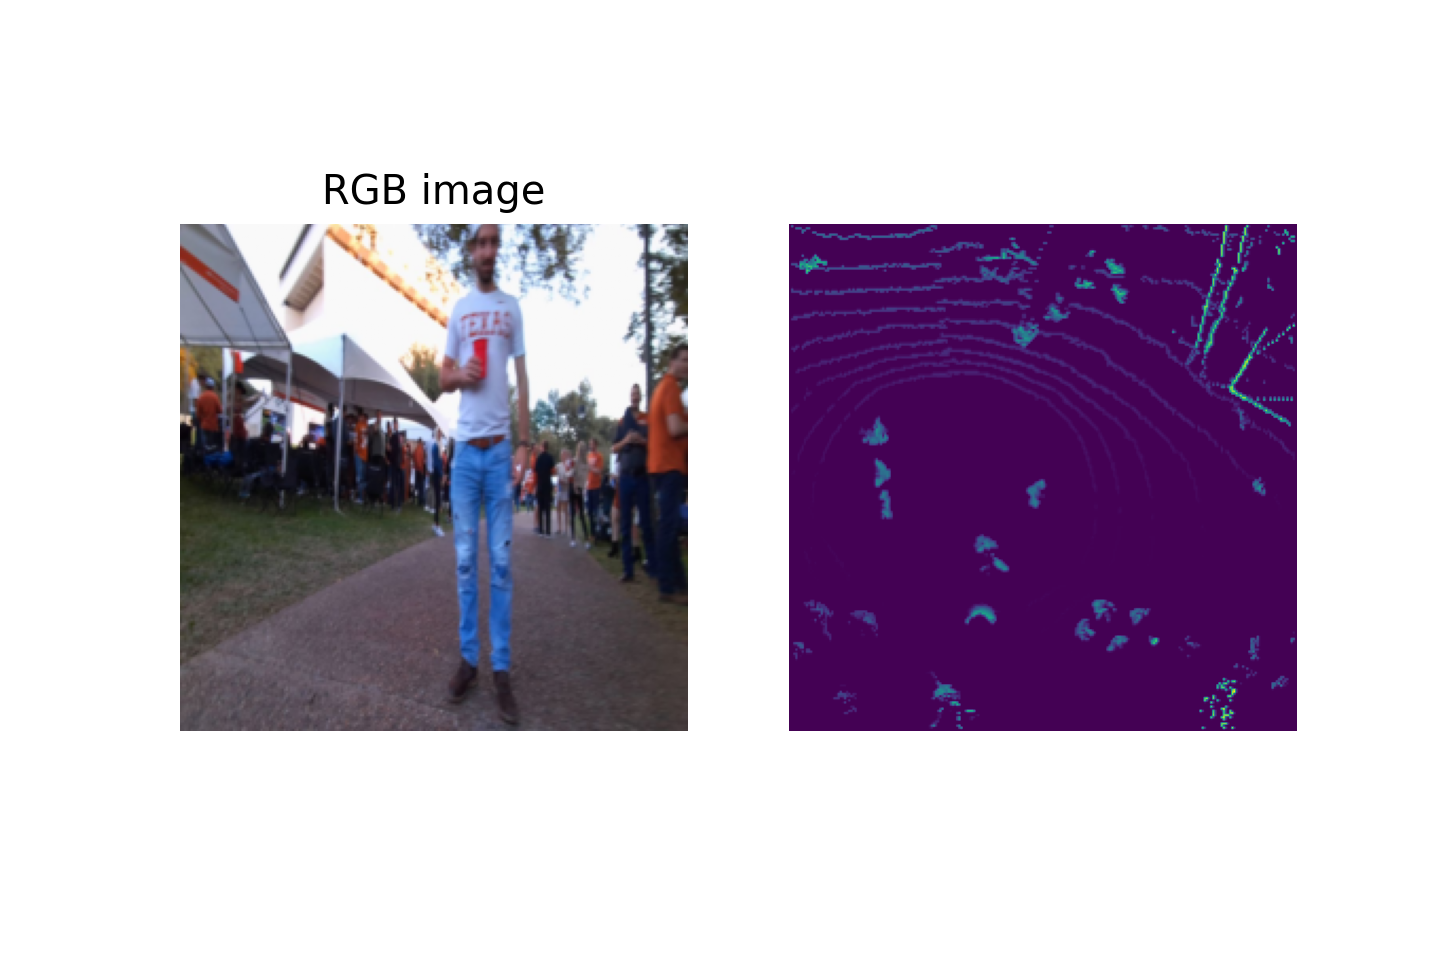

torch.Size([3, 240, 240]) torch.Size([1, 240, 240]) torch.Size([6, 2]) torch.Size([15, 32, 2]) 15


In [19]:
import matplotlib.pyplot as plt
import torch
%matplotlib notebook
idx = 740
t = trainset[idx]
rgb, lidar, pose, mot, num_obj = t[0], t[1], t[2], t[3], t[4]
mask = np.zeros((240,240))
mask[:,:] = 0.2
mask[65:150,110:200] = 1
#mask = np.expand_dims(mask, axis=2)
result = torch.from_numpy(rgb.numpy()*mask)
fig, axs = plt.subplots(1,2, dpi=120)
axs[0].axis("off")
axs[0].set_title("RGB image")
axs[1].axis("off")
axs[0].imshow(rgb.permute(1,2,0).numpy())
#axs[1].imshow(result.permute(1,2,0).numpy())
axs[1].imshow(lidar.permute(1,2,0).numpy())
# rgb = rgb.unsqueeze(dim=0)
# lidar = lidar.unsqueeze(dim=0)
# pose = pose.unsqueeze(dim=0)
# mot = mot.unsqueeze(dim=0)
print(rgb.shape, lidar.shape, pose.shape, mot.shape, num_obj)

In [18]:
from imutils.object_detection import non_max_suppression
from imutils import paths
import imutils

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
img_dir = "./data/A_Spot_LBJ_Stadium_Sat_Nov_13_105_rgb_img"
save_dir = f"./video/A_Spot_LBJ_Stadium_Sat_Nov_13_105"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

color_map = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (255, 255, 0), # Yellow
    (0, 255, 255), # Cyan
    (255, 0, 255)  # Magenta
]
    
for n in tqdm(range((len(os.listdir(img_dir))))):
    f_name = f'{n}.png'
    image = cv2.imread(f'{img_dir}/{f_name}')
    image = imutils.resize(image, width=min(400, image.shape[1]))
    
    # detect people in the image
    (rects, weights) = hog.detectMultiScale(image, winStride=(4, 4),
        padding=(8, 8), scale=1.05)

    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
    # draw the final bounding boxes
    for i, (xA, yA, xB, yB) in enumerate(pick):
        color = color_map[i % len(color_map)]
        cv2.rectangle(image, (xA, yA), (xB, yB), color, 2)
    # show some information on the number of bounding boxes
    #print("[INFO]: {} original boxes, {} after suppression".format(len(rects), len(pick)))
    # show the output images
    
    cv2.imwrite(f"{save_dir}/{f_name}",image)
    #cv2.imshow("After NMS", image)
    #cv2.waitKey(0)


100%|█████████████████████████████████████████████████| 3461/3461 [03:57<00:00, 14.56it/s]


In [45]:
video_name = "A_Spot_LBJ_Stadium_Sat_Nov_13_105.avi"
images = [img for img in os.listdir(save_dir)]
print(len(images))  
print(images[0]) 
# Array images should only consider
# the image files ignoring others if any
#print(images) 

frame = cv2.imread(os.path.join(save_dir, images[0]))
# print(frame)
# setting the frame width, height width
# the width, height of first image
height, width, layers = frame.shape  
print(frame.shape)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, 0, 20, (width, height)) 

# Appending the images to the video one by one
for image in images: 
    image = cv2.resize(cv2.imread(os.path.join(save_dir, image)), (height, width))
    video.write(image) 

# Deallocating memories taken for window creation
# cv2.destroyAllWindows() 
video.release() 

3461
229.png
(225, 400, 3)


<IPython.core.display.Javascript object>


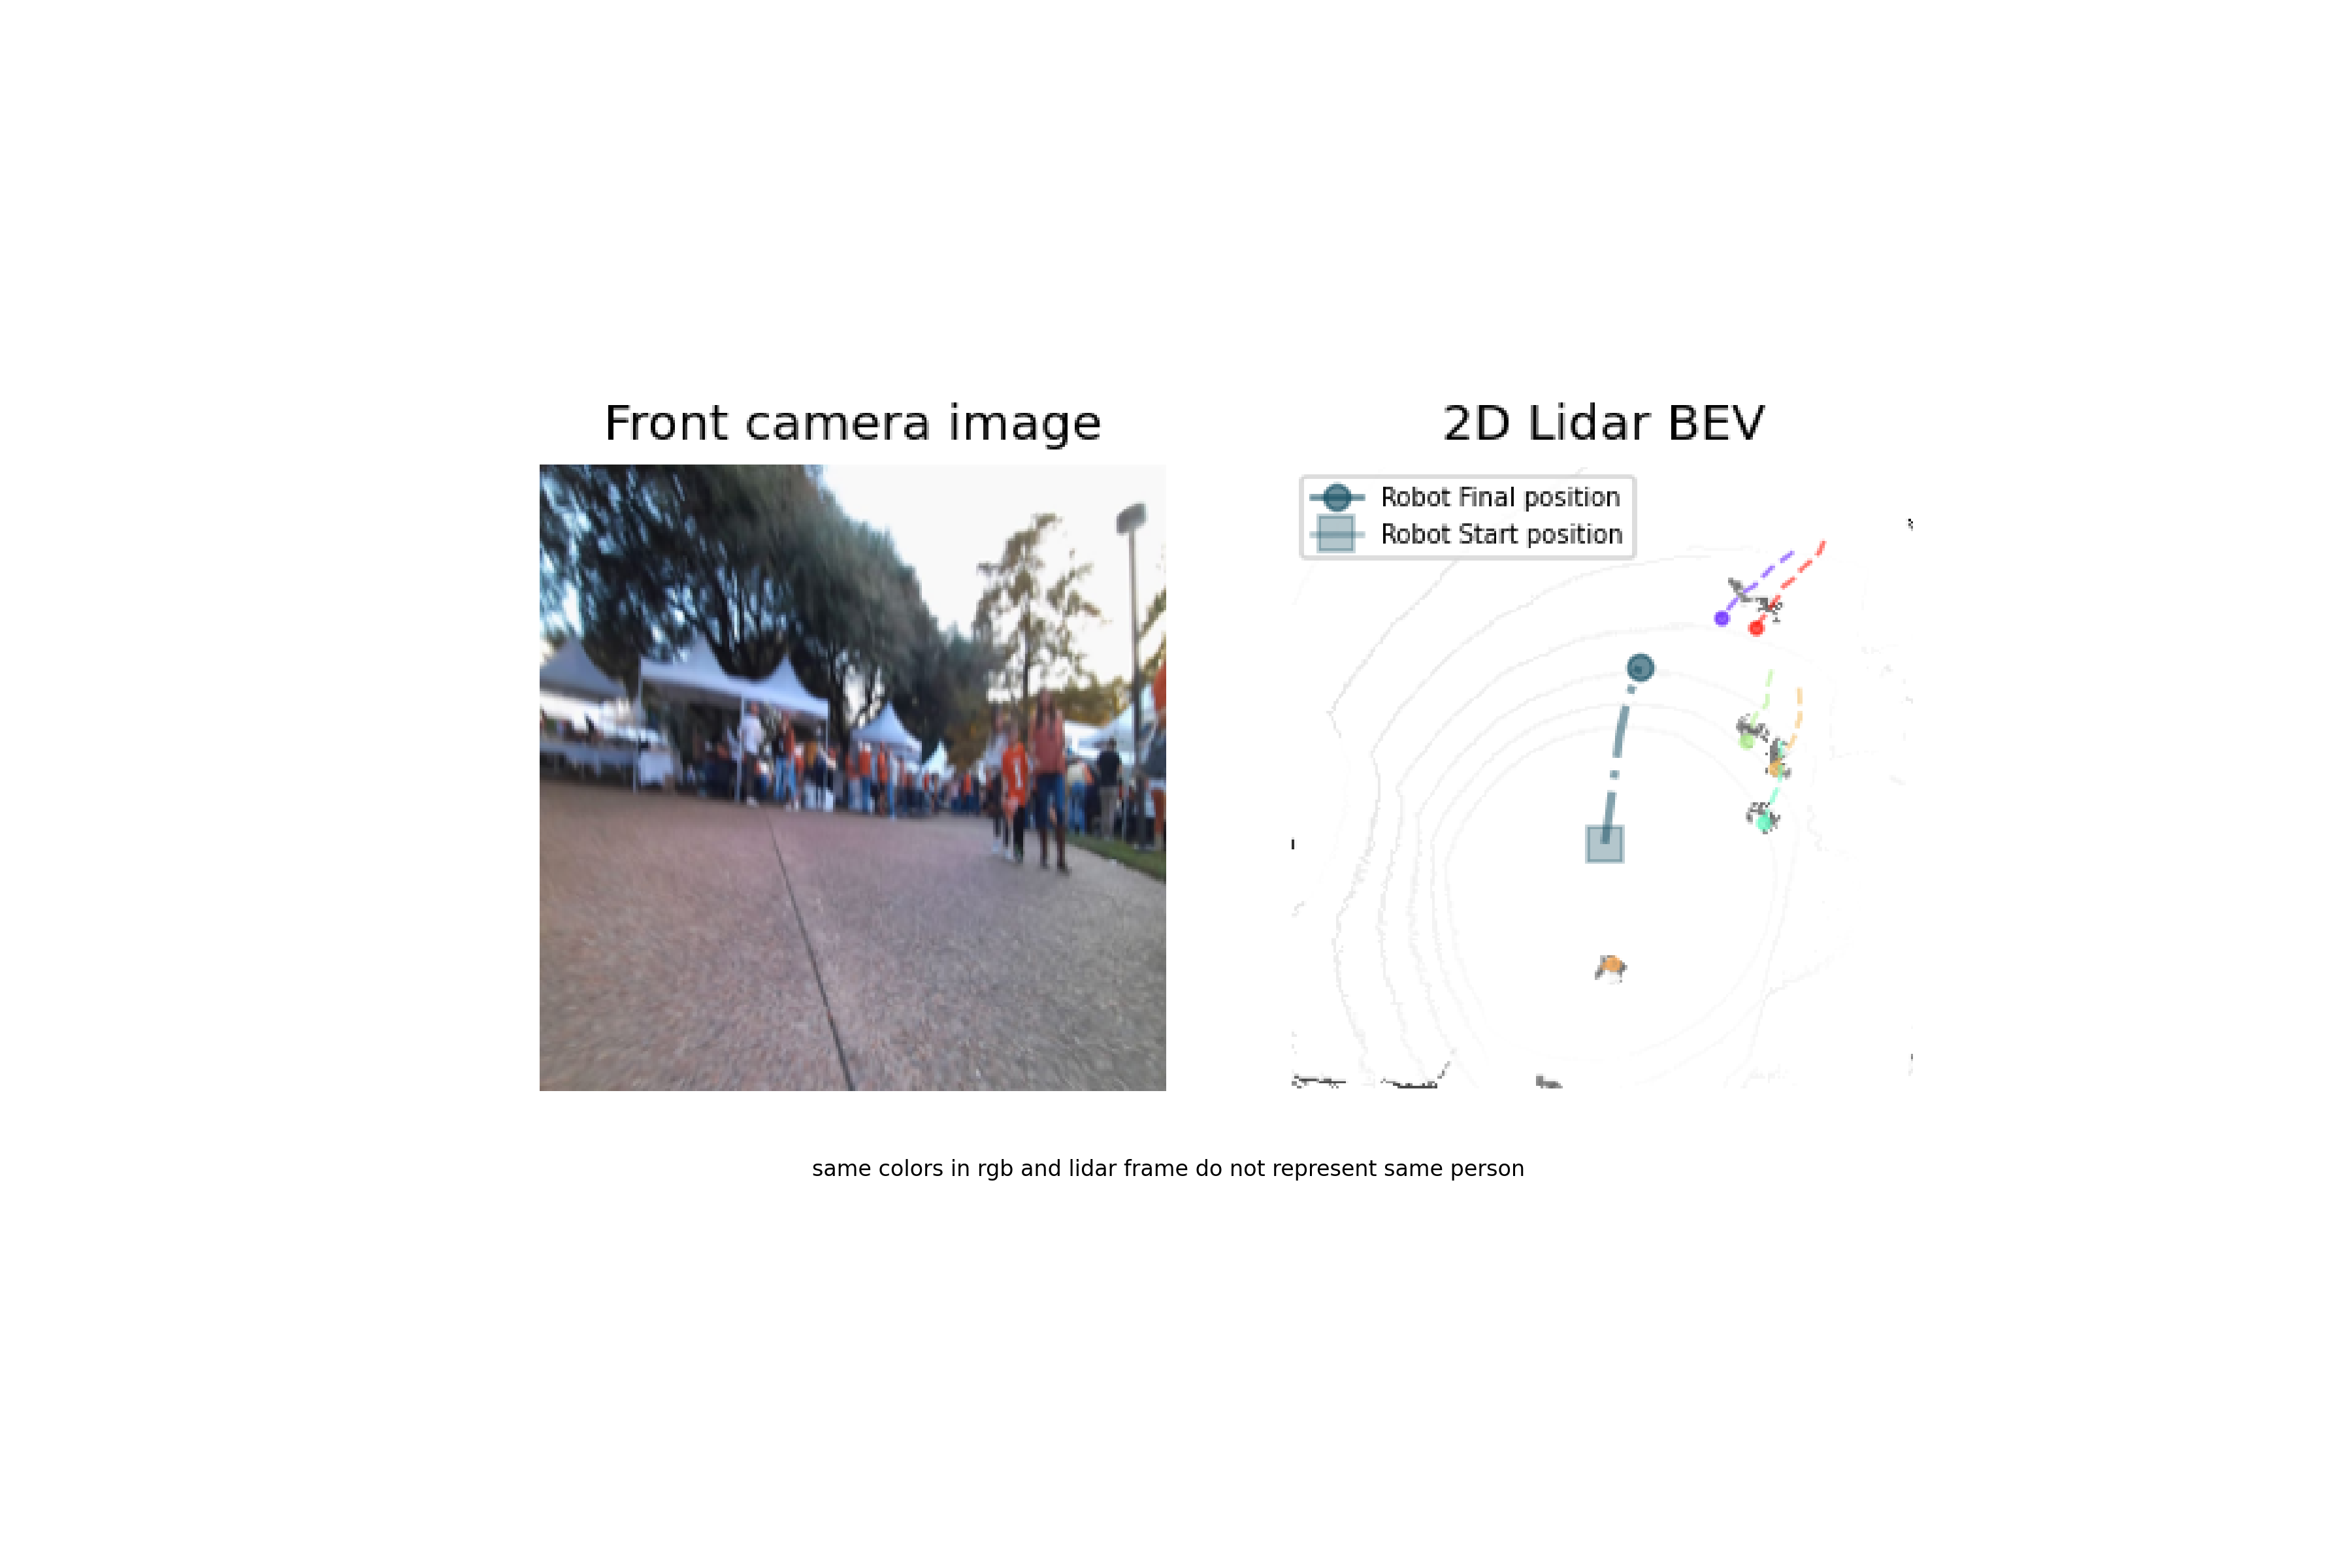

In [2]:
fig, ax = plt.subplots(dpi=300)
ax.axis("off")
ax.annotate('same colors in rgb and lidar frame do not represent same person',
            xy = (200, 400),
#             xycoords='axes fraction',
#             ha='right',
#             va="center",
            fontsize=4)
ims = []
idx = 57
for i in range(450,1470):
    with Image.open(f"./video/A_Spot_LBJ_Stadium_Sat_Nov_13_105_combined/{i}.png") as img:
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True, repeat=False)
writervideo = animation.FFMpegWriter(fps=20)
ani.save("A_Spot_LBJ_Stadium_Sat_Nov_13_105.mp4",writervideo)

(10, 7, 2)


<IPython.core.display.Javascript object>


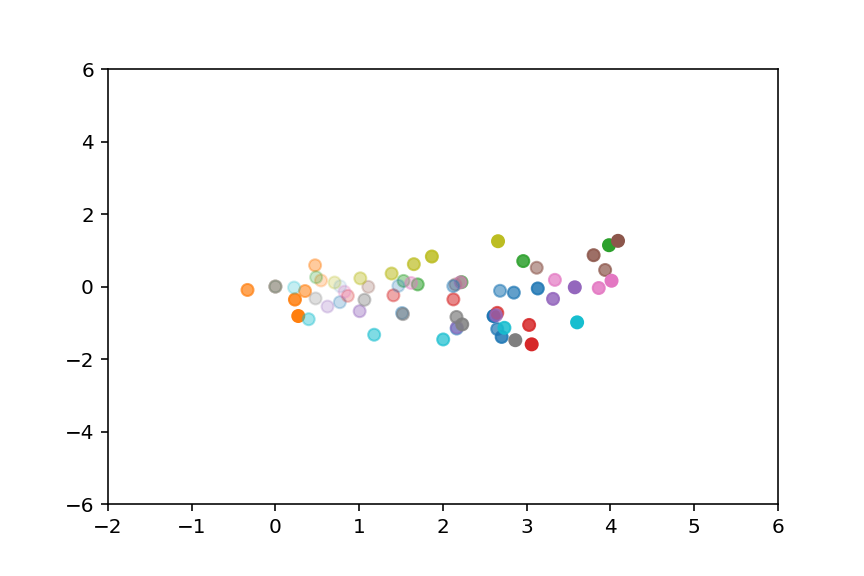

(-6.0, 6.0)

In [8]:
import numpy as np
alphas = np.linspace(0.1, 1, 7)
generated_paths_tensor = generator.generate_path(rgb, lidar).detach()
generated_paths = generated_paths_tensor.numpy()
print(generated_paths.shape)
plt.figure()

for i in range(len(generated_paths)):
    plt.scatter(generated_paths[i,:,0], generated_paths[i,:,1],alpha=alphas, label=f"rob_path_{i}")
# i = 8
# plt.scatter(generated_paths[i,:,0], generated_paths[i,:,1],alpha=alphas, label=f"rob_path_{i}")
plt.scatter(pose[:,0], pose[:,1], alpha=alphas, label="gt")
plt.xlim(-2,6)
plt.ylim(-6,6)
#plt.legend(loc=0)

In [8]:
# rgb_n = rgb.unsqueeze(dim=0)
# lidar_n = lidar.unsqueeze(dim=0)
# pose_n = pose.unsqueeze(dim=0)
# mot_n = mot.unsqueeze(dim=0)
# gen,pose_out,enc_1 = model.generate_seq(rgb_n,lidar_n,pose_n,8)
# gen = gen.detach().numpy()
# pose_out = pose_out.detach().numpy()
# g,_,_ = model.forward(rgb_n,lidar_n,pose_n,mot_n)
# g = g.detach().numpy()
# #print(model.enable_rob_dec)
# #print(pose_n,g,gen)
# pose = pose.numpy()

<IPython.core.display.Javascript object>


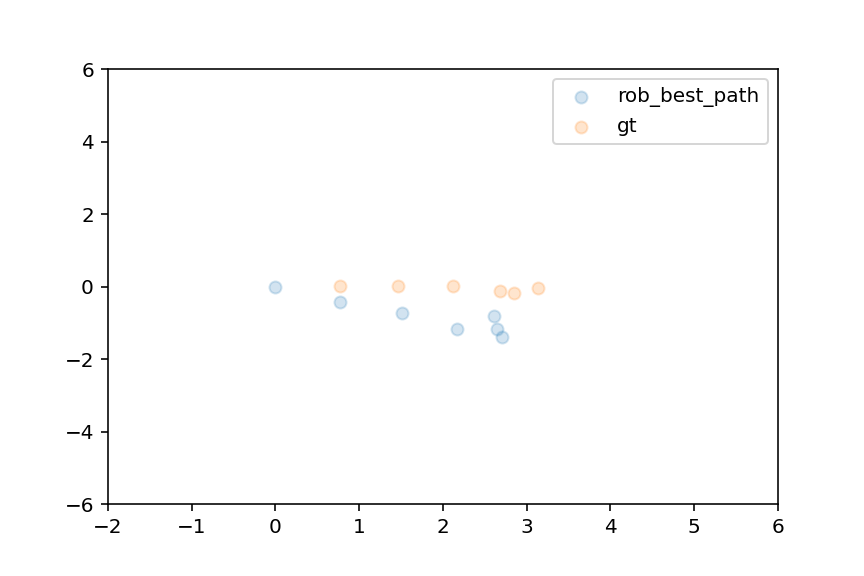

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


In [9]:

plt.figure()

best_path, min_coll = generator.select_best(generated_paths_tensor, mot, num_obj, criteria="diat")
best_path = best_path.detach().numpy()
print(min_coll)
plt.scatter(best_path[:,0], best_path[:,1],alpha=0.2, label="rob_best_path")
#plt.scatter(gen[0,:,0], gen[0,:,1], alpha=0.2, label="gen")
plt.scatter(pose[:,0], pose[:,1], alpha=0.2, label="gt")
#plt.scatter(pose_out[0,:,0], pose_out[0,:,1], alpha=0.1, label="pose_out")
#for i in range(num_obj):
#    plt.scatter(mot[i,5::5,0], mot[i,5::5,1], color="r", alpha=alphas)
plt.xlim(-2,6)
plt.ylim(-6,6)
plt.legend()

<IPython.core.display.Javascript object>


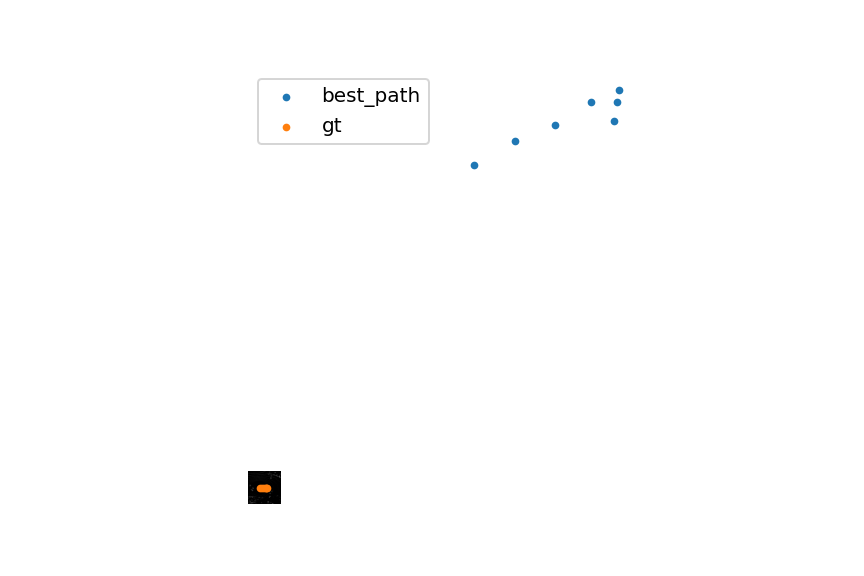

In [13]:
plt.figure()
plt.axis('off')
plt.imshow(lidar.permute(1,2,0).numpy(), cmap = plt.cm.gray)
dx = 4/0.05
dy = 6/0.05
#genx = (dx + (gen[0,:,0] / 0.05))
#geny = (dy - (gen[0,:,1] / 0.05))
bestx = (dx + (best_path[:,0] / 0.05))
besty = (dy - (best_path[:,1]) / 0.05)
gtx = (dx + (pose[:,0] / 0.05))
gty = (dy - (pose[:,1]) / 0.05)
for i in range(len(generated_paths)):
    generated_paths[i,:,0] = (dx + generated_paths[i,:,0] / 0.05)
    generated_paths[i,:,1] = (dy - generated_paths[i,:,1] / 0.05)
#plt.scatter(genx, geny, s=8, label="gen")
plt.scatter(bestx, besty, s=8, label="best_path")
plt.scatter(gtx, gty, s=8, label="gt")

plt.legend()

In [ ]:
import pylab
color = plt.cm.rainbow(np.linspace(0, 1, len(data)))
np.random.seed(39)
np.random.shuffle(color)
dx = 4/0.05
dy = 6/0.05

# Get the number of trajectories and the number of steps in each trajectory
n_traj = len(data)
memory = 15 # number of past frames to include in the visualization of each trajectory


save_dir = f"./video/A_Spot_LBJ_Stadium_Sat_Nov_13_105_combined"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
def get_images(number):
    #pylab.ioff()
    for j in tqdm(range(memory+3, memory+number)):
        t = trainset[j]
        rgb, lidar, pose, mot, num_obj = t[0], t[1], t[2], t[3], t[4]
        gty = (dx + (pose[:,0] / 0.05))
        gtx = (dy - (pose[:,1]) / 0.05)
        f_name = str(j) + '.png'
        I = Image.open(f'{lidar_bev_dir}/{f_name}')
        R = Image.open(f'./video/A_Spot_LBJ_Stadium_Sat_Nov_13_105/{f_name}').resize((241,241))
        I = I.rotate(-90)
        I = ImageOps.mirror(I)
        frame = np.array(I)
        frame_R = np.array(R)
        loc = frame > 30
        frame[loc] = frame[loc] + 50
        loc = (frame < 30) & (frame > 20)
        frame[loc] = frame[loc] - 20
        fig, axs = plt.subplots(1, 2, dpi=120) #figsize=(7, 3.5), 
        axs[0].axis('off')
        axs[1].axis('off')
        axs[0].imshow(frame_R, cmap = plt.cm.gray.reversed())#, origin='lower')
        #axs[0].set_title('2D Lidar BEV')
        axs[0].set_title('Front camera image')
        axs[1].imshow(frame, cmap = plt.cm.gray.reversed(), origin='lower')
        axs[1].set_title('2D Lidar BEV')
        #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        for i in range(len(data)):
            c = color[i]
            if (data[i][j] != 0):
                l = data[i][j-memory:j+1]
                while 0 in l:
                    l.remove(0)

                x, y = [],[]
                if(type(l)!=int):
                    for item in l:
                        x.append(item[0])
                        y.append(item[1])

                #x = [241,240,239,238,237,236,235,234,233,232]
                #y = [1,2,3,4,5,6,7,8,9,10]
                axs[1].plot(x, y, c=c, linestyle="dashed", linewidth=1.1, alpha=0.6)
                axs[1].scatter(x[-1],y[-1],color=c,s=8,alpha=0.7)
        axs[1].plot(gtx, gty, color='#064358', linestyle="dashdot", linewidth=2, alpha=0.5) ##064358
        axs[1].plot(gtx[-1],gty[-1], color='#064358', marker='o', markersize=6, alpha=0.6, label="Robot Final position") 
        axs[1].plot(gtx[0],gty[0], color='#064358', marker='s', markersize=8, alpha=0.3, label="Robot Start position") 

        axs[1].legend(loc='upper left',fontsize=6)
        # for i in range(len(generated_paths)):
        #     axs[0].plot(generated_paths[i,:,0], generated_paths[i,:,1], linestyle="dashed", linewidth=1.1, alpha=0.6)
        fig.savefig(f'{save_dir}/{f_name}')
        #pylab.ion()

get_images(1500)

In [ ]:
color = plt.cm.rainbow(np.linspace(0, 1, len(data)))
color

<IPython.core.display.Javascript object>


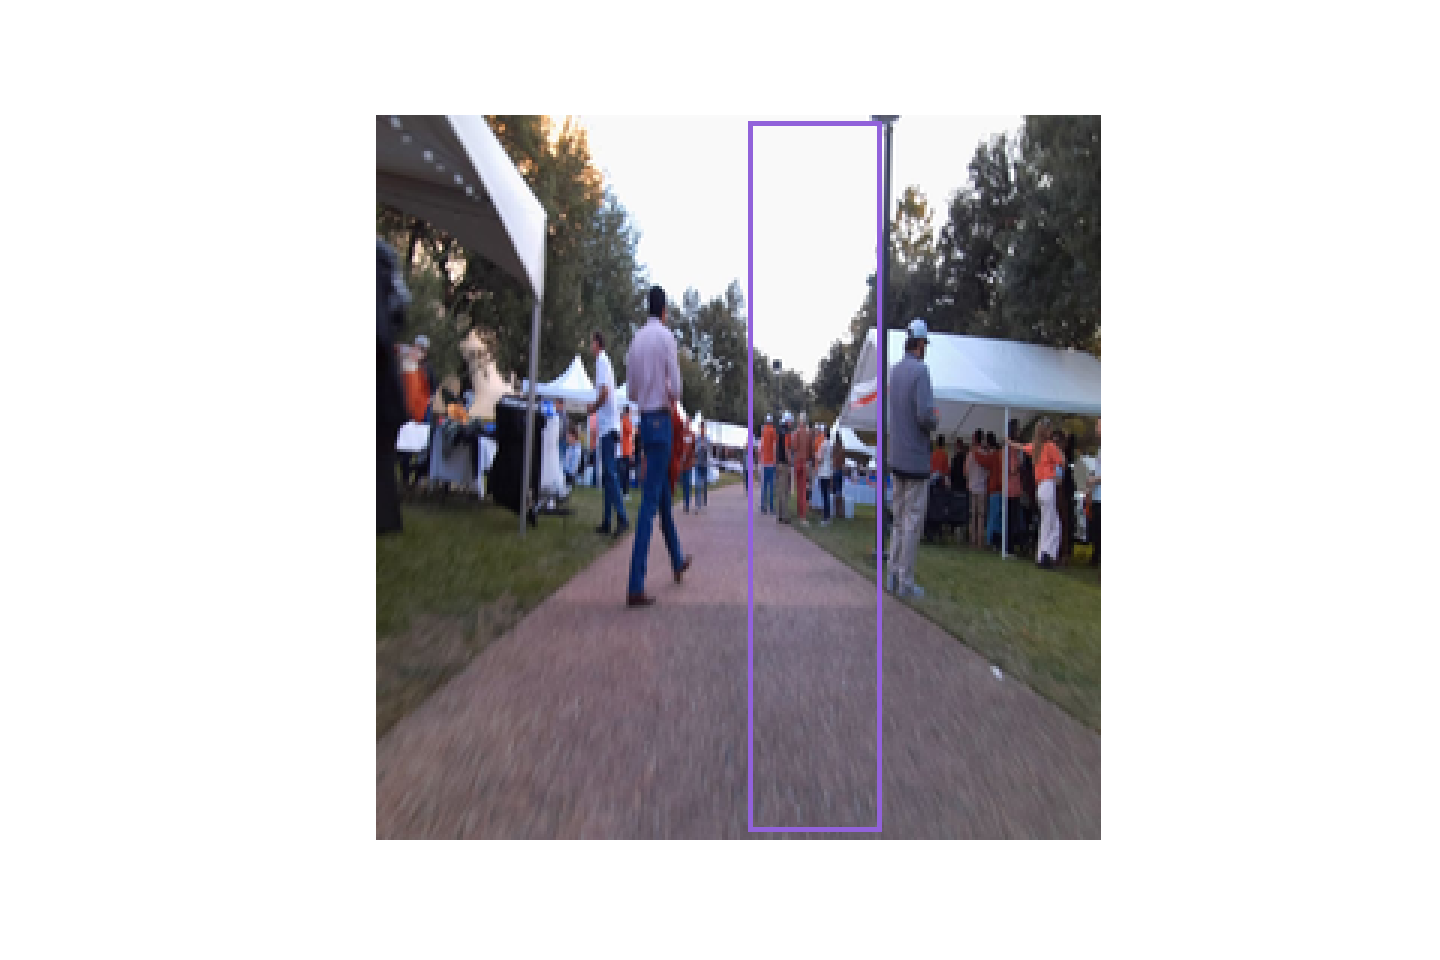

In [292]:
from matplotlib.patches import Rectangle
I = Image.open(f"./data/A_Spot_LBJ_Stadium_Sat_Nov_13_105_rgb_img/{f_name}").resize((241,241),Image.LANCZOS)
img = np.array(I)
fig, axs = plt.subplots(1,1,dpi=120)
#axs.figure(dpi=120)
axs.axis('off')
axs.imshow(img)
axs.add_patch( Rectangle((124,2),
                        43, 235,
                        fc ='none', 
                        ec ='#9162DA',
                        lw = 1.5,
                        label='moving in the path of bot') )

# axs.add_patch( Rectangle((183,47),
#                         30, 150,
#                         fc ='none', 
#                         ec ='#ED5A0B',
#                         lw = 1.5) )

# axs.add_patch( Rectangle((208,37),
#                         20, 160,
#                         fc ='none', 
#                         ec ='#0B7CED',
#                         lw = 1.5) )
#fig.savefig('./images/example1_rgb_frame4.png')
# (125,15),
#                         39, 190,

<IPython.core.display.Javascript object>


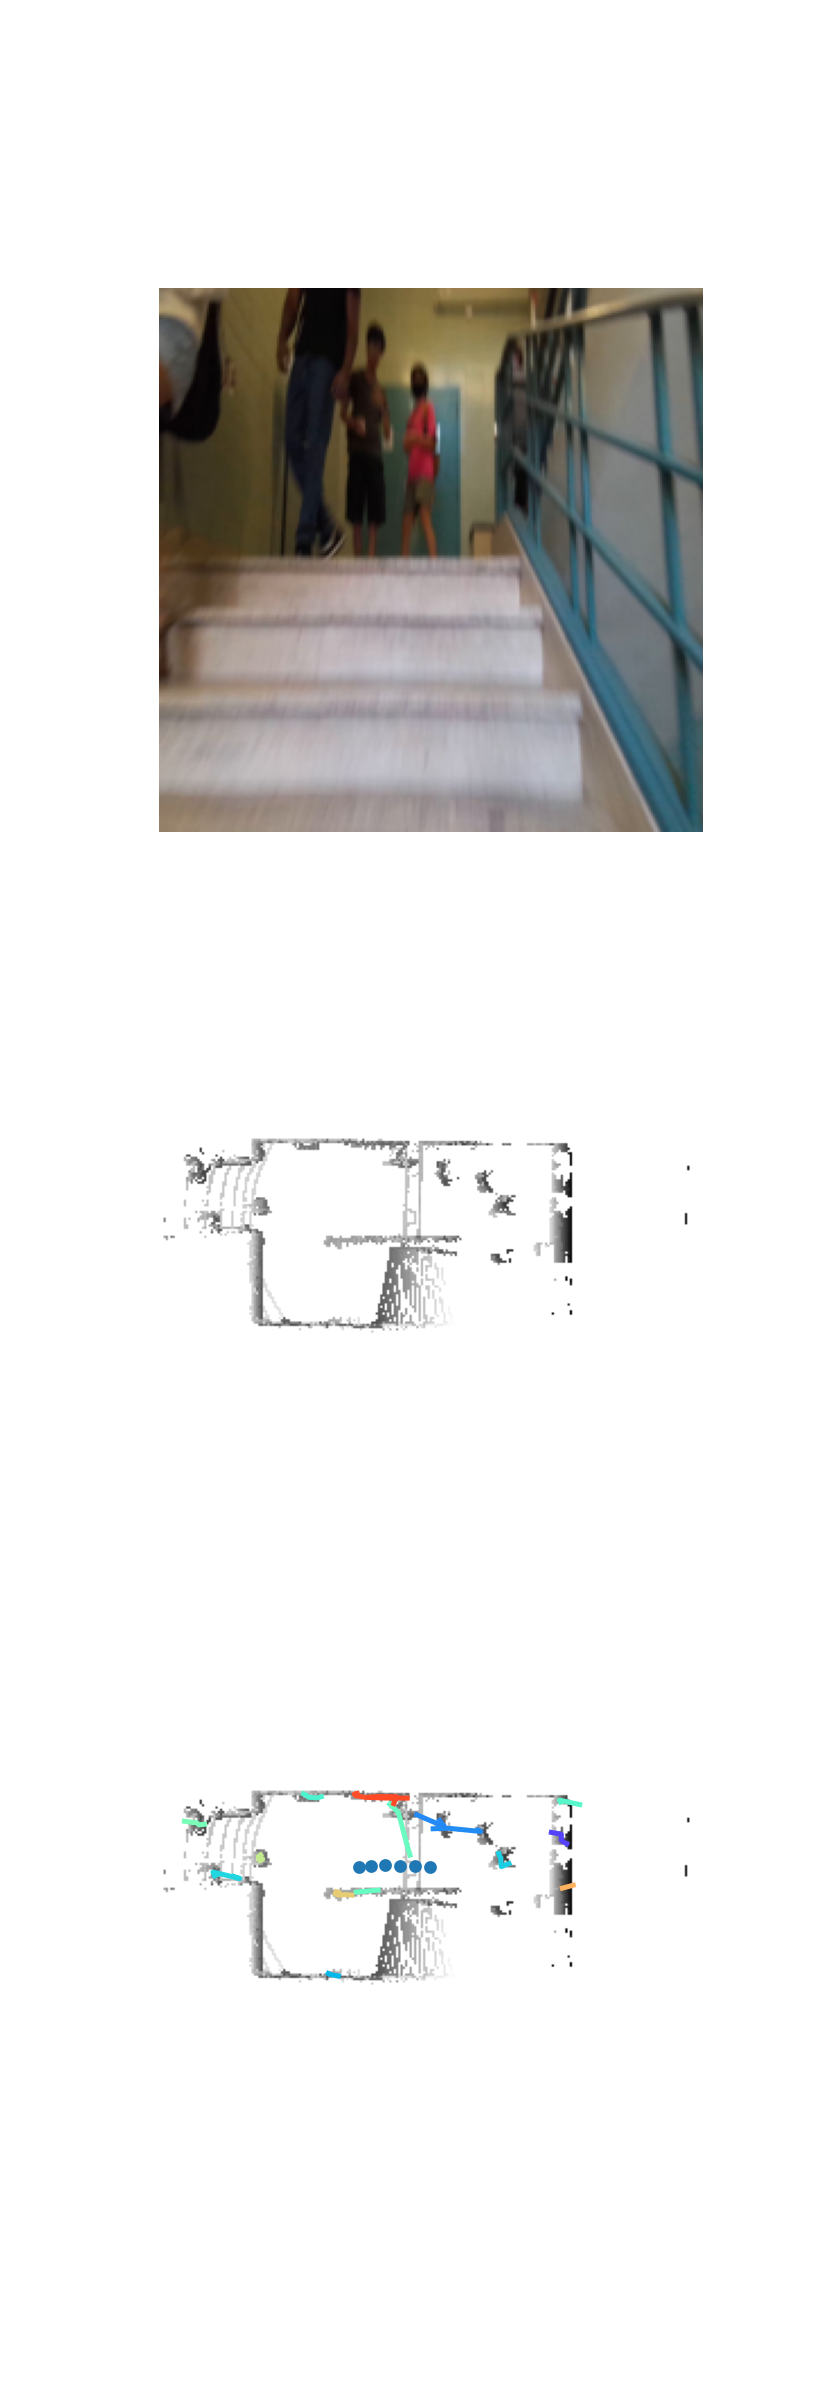

In [186]:
fig, axs = plt.subplots(3,1,figsize=(3.5,10),dpi=120)
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
#axs[3].axis("off")
axs[0].imshow(rgb.permute(1,2,0).numpy())
axs[1].imshow(frame, cmap = plt.cm.gray.reversed())
axs[2].imshow(frame, cmap = plt.cm.gray.reversed())
#axs[3].imshow(frame, cmap = plt.cm.gray.reversed())
for i in range(len(data)):
    c = color[i]
    if (data[i][j] != 0):
        l = data[i][j-memory:j+1]
        while 0 in l:
            l.remove(0)

        x, y = [],[]
        if(type(l)!=int):
            for item in l:
                x.append(item[1])
                y.append(item[0])
        
        #x = [241,240,239,238,237,236,235,234,233,232]
        #y = [1,2,3,4,5,6,7,8,9,10]
        axs[2].plot(x, y, c=c)
axs[2].scatter(gtx, gty, s=8, label="best_path")

In [187]:
filepath = f'./images/A_Spot_Parlin_Parlin_Wed_Nov_10_51_idx_{idx}.png'
fig.savefig(filepath)

<IPython.core.display.Javascript object>


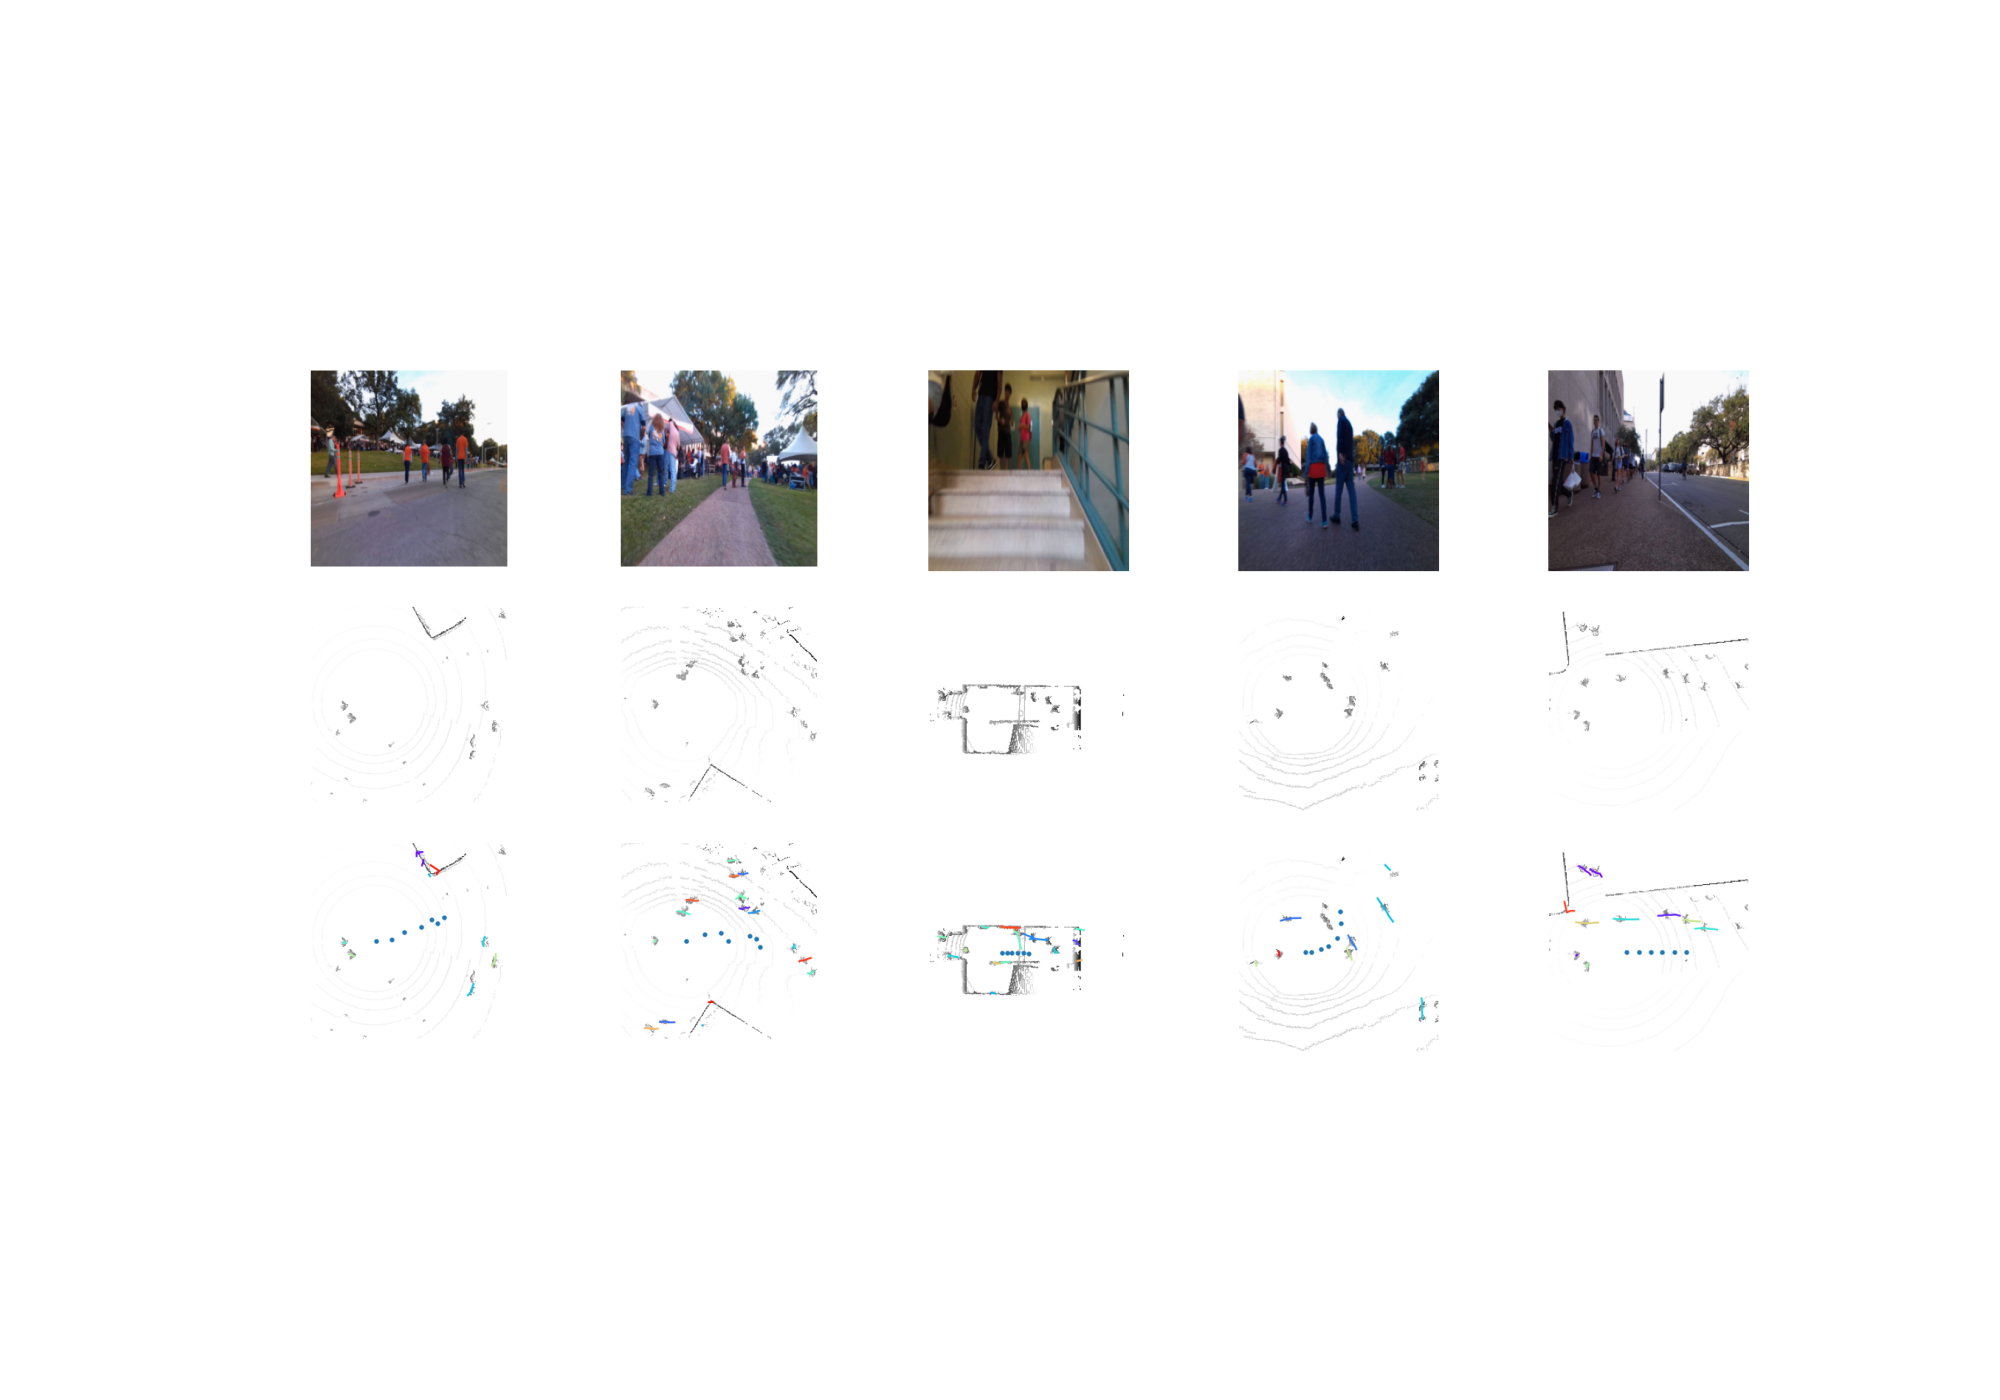

In [210]:
I = []

I.append(np.array(Image.open('./images/A_Spot_Butler_LBJ_Sat_Nov_13_104_idx_30.png')))
I.append(np.array(Image.open('./images/A_Spot_Butler_LBJ_Sat_Nov_13_104_idx_350.png')))
I.append(np.array(Image.open('./images/A_Spot_Parlin_Parlin_Wed_Nov_10_51_idx_60.png')))
I.append(np.array(Image.open('./images/A_Spot_Butler_LBJ_Sat_Nov_13_104_idx_880.png')))
I.append(np.array(Image.open('./images/A_Spot_Library_Fountain_Tue_Nov_9_35_idx_750.png')))


fig, axs = plt.subplots(1, 5, figsize=(10,7))
for i in range(len(I)):
    axs[i].axis("off")
    axs[i].imshow(I[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)

<IPython.core.display.Javascript object>


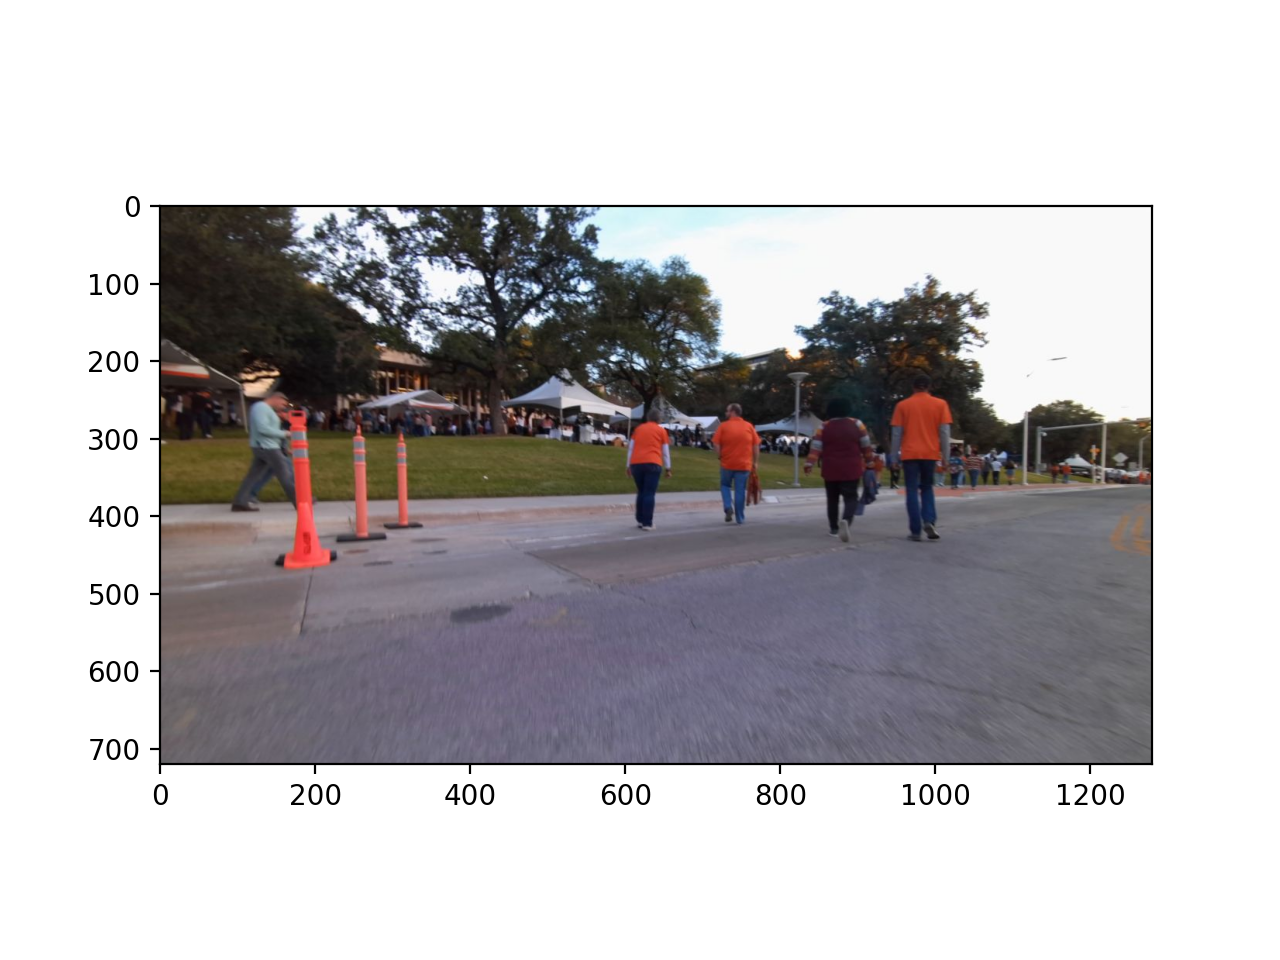

In [213]:
I = np.array(Image.open('./data/A_Spot_Butler_LBJ_Sat_Nov_13_104_rgb_img/30.png'))
plt.figure()
plt.imshow(I)
